In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from tensorflow import keras
import keras_tuner as kt


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("C:/Users/sreek.SREEKAR/Downloads/fire_images")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'fire':
        categories.append(1)
    else:
        categories.append(0)
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head(5)

,filename,category
0,fire.1.png,1
1,fire.10.png,1
2,fire.100.png,1
3,fire.101.png,1
4,fire.102.png,1


<AxesSubplot:>

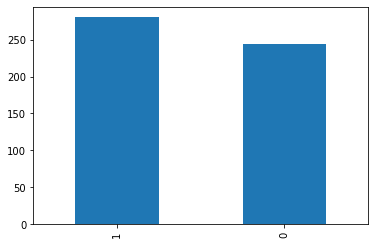

In [5]:

df['category'].value_counts().plot.bar()

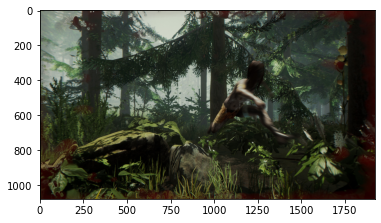

In [6]:
sample = random.choice(filenames)
image = load_img("C:/Users/sreek.SREEKAR/Downloads/fire_images/"+sample)
plt.imshow(image)

In [7]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [8]:
earlystop = EarlyStopping(patience=4)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
df["category"] = df["category"].replace({0: 'non_fire', 1: 'fire'}) 

In [10]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

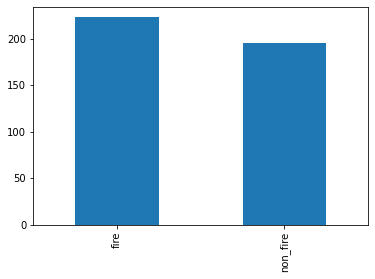

In [11]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

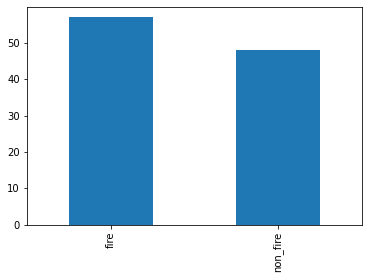

In [12]:

validate_df['category'].value_counts().plot.bar()

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/sreek.SREEKAR/Downloads/fire_images/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 419 validated image filenames belonging to 2 classes.


In [16]:

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/sreek.SREEKAR/Downloads/fire_images/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 105 validated image filenames belonging to 2 classes.


In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/sreek.SREEKAR/Downloads/fire_images/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


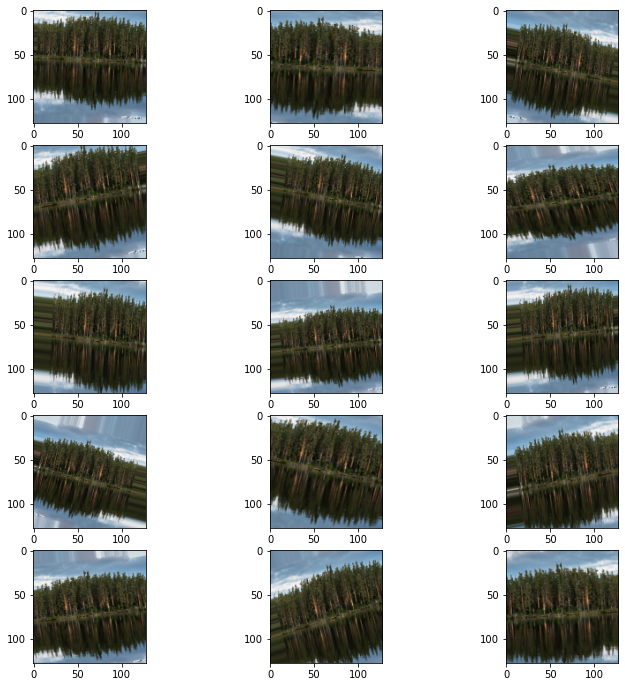

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

In [19]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model1.h5")

Epoch 1/50
27/27 [==============================] - 42s 1s/step - loss: 0.7497 - accuracy: 0.8296 - val_loss: 0.5103 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 39s 1s/step - loss: 0.4171 - accuracy: 0.8639 - val_loss: 0.8726 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.8738
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/27 [==============================] - 38s 1s/step - loss: 0.4587 - accuracy: 0.8738 - val_loss: 2.1427 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 38s 1s/step - loss: 0.2978 - accuracy: 0.9010 - val_loss: 0.9847 - val_accuracy: 0.5429 - lr: 5.0000e-04
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8812
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
27/27 [==============================] - 38s 1s/step - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


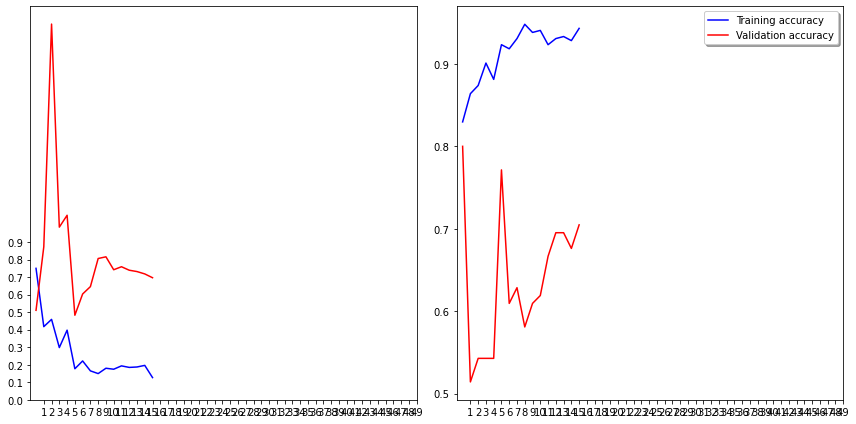

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(10):
    all_test_images = os.listdir("C:/Users/sreek.SREEKAR/Downloads/test")
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'C:/Users/sreek.SREEKAR/Downloads/test/{random_image}')
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(['fire','not_fire'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 227ms/step
not_fire
